Goal: Use data from [phoible](https://phoible.org/) to learn a useful embedding from phonological feature space to a vector space in which distances between allophones tend to be small. Go to the [phoible project github](https://github.com/phoible/dev/tree/master/data) and grab phoible.csv for this exploration.

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn

class EmbedPhones(nn.Module):

    def __init__(self, num_features):
        super(EmbedPhones, self).__init__()
        
        self.res = nn.Linear(num_features,num_features,bias=False)
#         identity=torch.from_numpy(np.identity(num_features,dtype=np.dtype('float32')))
        with torch.no_grad():
            self.res.weight.normal_(0,0.02)
#             self.embed.weight += identity
        
    def forward(self, x):
        
        return x+self.res(x) # res represents the difference between the embedding map and the identity map


In [3]:
import os,sys
def add_path_to_local_module(module_name):
    module_path = os.path.abspath(os.path.join(module_name))
    if module_path not in sys.path:
        sys.path.append(module_path)
add_path_to_local_module("epitran")
add_path_to_local_module("panphon")

import panphon.featuretable
ft = panphon.featuretable.FeatureTable()

In [42]:
class PanphonNoLikey(Exception):
    pass

class NoAvailableData(Exception):
    pass

def to_panphon_fts(ipa_symbols):
    """ Convert a string of ipa symbols to a torch matrix whose rows are features.
        Do not include duplicates when panphon identifies symbols in terms of features. """
    if ipa_symbols == "NA" :  raise NoAvailableData("The string you gave indicates that there's no allophone data")
    fts = ft.word_to_vector_list(ipa_symbols,numeric=True)
    if not fts : raise PanphonNoLikey("Panphon does not recognize the IPA symbol "+str(ipa_symbols))
    fts = np.array(fts) 
    fts = np.unique(fts,axis=0) # panphon will identify some things; this gets rid of duplicates
    fts = fts.astype(np.dtype('float32'))
    return torch.from_numpy(fts)

feats = to_panphon_fts('ɛ æ')
num_features = len(feats[0])
print(num_features," features for 'ɛ æ':\n",feats)
emb = EmbedPhones(num_features)
emb(feats)

22  features for 'ɛ æ':
 tensor([[ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1., -1., -1., -1., -1., -1., -1.],
        [ 1.,  1., -1.,  1., -1., -1., -1.,  0.,  1., -1., -1.,  0., -1.,  0.,
         -1., -1.,  1., -1., -1., -1.,  1., -1.]])


tensor([[ 0.9486,  0.9451, -1.0057,  1.0384, -0.9933, -0.9214, -0.8904,  0.0118,
          1.0741, -1.0438, -0.8976, -0.0408, -0.8806,  0.1583, -1.0287, -0.8424,
         -1.0076, -1.0662, -0.9870, -1.2064, -1.0250, -0.7921],
        [ 0.8831,  0.8563, -0.9621,  1.0578, -1.0437, -0.9246, -0.9461,  0.1144,
          1.1458, -1.0647, -0.9020, -0.0454, -1.0274,  0.0675, -0.9158, -0.8595,
          1.0839, -1.0030, -0.8824, -1.1644,  0.9948, -0.8598]],
       grad_fn=<AddBackward0>)

In [75]:
class SuppressedMessenger(object):
    """ A class to output messages with output being supressed at a certain point."""
    def __init__(self,name,max_messages):
        self.name = name
        self.num_printed = 0
        self.max_messages = max_messages
        self.stopped_printing = False if max_messages > 0 else True

    def print(self,msg):
        if self.num_printed < self.max_messages:
            print(msg)
            self.num_printed += 1
        elif not self.stopped_printing:
            print("[Further output regarding "+self.name+" will be suppressed]")
            self.stopped_printing = True

In [135]:
import csv

feat_vals = {'+':1,'-':-1,'0':0}

to_phoible_feats_dict = {}

f = open('phoible.csv')
reader = csv.reader(f)
head = next(reader)
phoneme_index = head.index('Phoneme')
langkey_index = head.index('ISO6393')
first_feat_index = head.index('tone')
last_feat_index = head.index('click')
skipped_msg = SuppressedMessenger("bad feature labels", 10)
contradiction_msg = SuppressedMessenger("phoible contradictions", 30)
print("Building mapping from phoible phonemes to feature space...")
for i,row in enumerate(reader):
    phoneme = row[phoneme_index]
    raw_feats = row[first_feat_index:last_feat_index+1]
#     if any(len(feat)>1 for feat in raw_feats):
#         skipped_msg.print("Skipping phoneme "+phoneme+": multiple feature labels")
    #Instead lets add together multiple feature labels
    
    try:
        feats = np.array([sum(feat_vals[v] for v in val.split(',')) for val in raw_feats],dtype=np.dtype('float32'))
    except KeyError:
        skipped_msg.print("Skipping phoneme "+phoneme+": weird feature label")
    if phoneme in to_phoible_feats_dict.keys():
        if not np.array_equal(feats,to_phoible_feats_dict[phoneme]):
            contradiction_msg.print("Phoible contradiction for phoneme "+phoneme+"; language "+row[langkey_index]+" conflicts w/ prev entry")
    else:
        to_phoible_feats_dict[phoneme] = feats
f.close()

Building mapping from phoible phonemes to feature space...
Skipping phoneme ɹ̪̹̩: weird feature label
Skipping phoneme ɻ̹̩: weird feature label
Skipping phoneme ɹ̪̹̩: weird feature label


In [136]:
num_features = len(to_phoible_feats_dict['a'])
len(to_phoible_feats_dict),num_features

(3183, 37)

In [180]:
# will need to convert some ipa segs produced by epitran into the representation in phoible
epitran_to_phoible_replacements = {
    'd͡ʒ':'d̠ʒ',
    't͡ʃ':'t̠ʃ',
    't͡ɕ':'tɕ',
    't͡s':'ts',
    'd͡ʑ':'dʑ',
}

def epitran_to_phoible(epitran_ipa):
    phoible_ipa = epitran_ipa
    for a,b in epitran_to_phoible_replacements.items():
        phoible_ipa = phoible_ipa.replace(a,b)
    return phoible_ipa

In [162]:
class NoPhoibleFeatures(Exception):
    pass

def to_phoible_fts(ipa_symbols):
    """ Convert a string of ipa symbols to a torch matrix whose rows are features.
        Do not include duplicates when panphon identifies symbols in terms of features. """
    if ipa_symbols == "NA" :  raise NoAvailableData("The string you gave indicates that there's no allophone data")
    fts=[]
    for ft in ipa_symbols.split():
        ft = epitran_to_phoible(ft)
        try:
            fts.append(to_phoible_feats_dict[ft])
        except KeyError:
            continue
    if not fts:
        raise NoPhoibleFeatures("All the phonemes in '"+ipa_symbols+"' are giving trouble")
    fts = np.array(fts) 
    fts = np.unique(fts,axis=0) # do not allow duplicates. TODO: actually you should raise error if you see duplicates; it's not supposed to happen with phoible
    fts = fts.astype(np.dtype('float32')) # this is not needed i think, dtype was already set
    return torch.from_numpy(fts)

In [97]:
import csv

def allophone_data_by_language(num_lists=np.inf):
    f = open('phoible.csv')
    reader = csv.reader(f)
    head = next(reader)
    allophones_index = head.index('Allophones')
    langkey_index = head.index('ISO6393')
    last_langkey = "not a lang key"
    num_yielded = 0
    for i,row in enumerate(reader):
        if row[langkey_index] != last_langkey:
#             print("About to yield data for language",last_langkey)
            last_langkey = row[langkey_index]
            if i!=0 and allophone_data:
                yield allophone_data
                num_yielded += 1
            if num_yielded >= num_lists: break
            allophone_data = []
        try:
            allophone_list = to_panphon_fts(row[allophones_index])
        except PanphonNoLikey: # We will just skip the entire list of allophones in this case
            continue
        except NoAvailableData: # We will just skip the entire list of allophones in this case
            continue
        allophone_data.append(allophone_list)
    f.close()

In [105]:
import csv

def allophone_data_by_language_phoible(num_lists=np.inf):
    f = open('phoible.csv')
    reader = csv.reader(f)
    head = next(reader)
    allophones_index = head.index('Allophones')
    langkey_index = head.index('ISO6393')
    last_langkey = "not a lang key"
    num_yielded = 0
    for i,row in enumerate(reader):
        if row[langkey_index] != last_langkey:
#             print("About to yield data for language",last_langkey)
            last_langkey = row[langkey_index]
            if i!=0 and allophone_data:
                yield allophone_data
                num_yielded += 1
            if num_yielded >= num_lists: break
            allophone_data = []
        try:
            allophone_list = to_phoible_fts(row[allophones_index])
        except NoAvailableData: # We will just skip the entire list of allophones in this case
            continue
        allophone_data.append(allophone_list)
    f.close()

In [98]:
allophone_data_by_language_list = list(allophone_data_by_language())

In [106]:
allophone_data_by_language_phoible_list = list(allophone_data_by_language_phoible())

In [9]:
import random

def allophone_data_by_language_shuffled():
    indices = list(range(len(allophone_data_by_language_list)))
    random.shuffle(indices)
    for index in indices:
        yield allophone_data_by_language_list[index]

In [107]:
import random

def allophone_data_by_language_phoible_shuffled():
    indices = list(range(len(allophone_data_by_language_phoible_list)))
    random.shuffle(indices)
    for index in indices:
        yield allophone_data_by_language_phoible_list[index]

In [10]:
def distinct_pairs(N):
    """Generate pairs of integers i<j such that 0 <= i < j < N"""
    for i in range(N):
        for j in range(i+1,N):
            yield i,j

In [11]:
def sqdist(x,y):
    """Return squared distance between two 1D torch tensors"""
    return ((x-y)**2).sum()

In [12]:
import torch.optim as optim

emb = EmbedPhones(num_features)
lr = 0.0001
optimizer = optim.Adam(emb.parameters(),lr=lr,weight_decay=1.)

In [ ]:
epochs = 4
costs = []
for e in range(epochs):
    for step_num,allophone_data in enumerate(allophone_data_by_language_shuffled()):

        allophone_dists   = 0.
        nallophone_dists  = 0. 

        optimizer.zero_grad()

        for allophone_list in allophone_data:
            for i,j in distinct_pairs(len(allophone_list)):
                allophone_dists += sqdist(emb(allophone_list[i]),emb(allophone_list[j]))
        for i,j in distinct_pairs(len(allophone_data)):
            for x in allophone_data[i]:
                for y in allophone_data[j]:
                    nallophone_dists += sqdist(emb(x),emb(y))

        cost = allophone_dists - 0.05 * nallophone_dists
        cost.backward()
        costs.append(cost.item())
        if step_num%50==0:
            print(step_num,"languages processed. Avg cost: ",np.mean(costs))
            costs = []
        optimizer.step()

In [13]:
emb.res.weight

Parameter containing:
tensor([[ 2.9702e-02, -1.2109e-02, -1.0308e-02, -1.3416e-02, -2.2243e-02,
          1.8969e-02,  3.0674e-03, -3.3947e-02,  4.4120e-02,  2.6205e-02,
          1.4750e-02, -1.9857e-03,  2.0973e-02, -1.4108e-02, -2.3543e-02,
         -3.8274e-02,  2.9040e-02,  2.8446e-02,  1.3219e-02, -1.7243e-02,
         -1.9335e-02, -1.7170e-02],
        [-3.2061e-02, -2.6353e-02,  5.6516e-03, -1.7991e-02, -1.1083e-02,
          9.3567e-03,  1.1627e-02, -3.8170e-03,  2.8208e-03, -4.8546e-03,
         -3.1288e-02, -1.3929e-02, -2.2132e-02,  1.5299e-02, -2.7837e-02,
         -3.2487e-02,  2.3885e-03, -2.5825e-03,  3.9956e-02,  7.3199e-03,
         -2.3272e-03,  1.3580e-02],
        [ 5.2027e-03, -3.7826e-03, -4.3033e-03,  1.4576e-02, -2.3403e-02,
          2.1581e-02, -4.2285e-03, -4.1415e-04,  9.5291e-03,  1.9187e-02,
         -1.7337e-02,  3.2390e-03,  2.8560e-02,  1.2132e-02,  6.0682e-05,
          1.7935e-03,  5.9884e-03, -1.4941e-02,  1.6826e-03,  1.6493e-02,
          9.8465e-

In [14]:
def dist(x,y):
    """distance between two feature vectors (1d torch tensors) after embedding"""
    return torch.sqrt(sqdist(emb(x),emb(y))).item()

Loading Epitran with language code ind-Latn... success!
6.927553176879883 0.9880602955818176


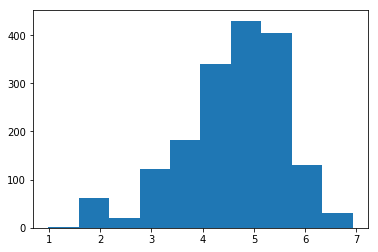

In [15]:
from wordgen import *
wg = WordgenLearned(3,"ind-Latn")

ipa_chars = wg.load_ipa_chars('eng-Latn')

dists = []
for c1 in ipa_chars:
    for c2 in ipa_chars:
        s1,s2 = to_panphon_fts(c1),to_panphon_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(dist(s1,s2))
max_dist,min_dist = max(dists),min(dists)
print(max_dist,min_dist)
plt.hist(dists)
plt.show()

In [25]:
ipa_chars = list(wg.load_ipa_chars('ind-Latn')) # now this is an ordered list, kind of serving as an enumeration
num_chars = len(ipa_chars)
projection = [n for n in range(num_chars)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = 25
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*500)
spread = step_size/2.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = np.random.normal(r0,spread)
    ipa_char_index = np.random.randint(num_chars)
    s0 = to_panphon_fts(ipa_chars[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_chars):
        s = to_panphon_fts(ipa_chars[n])
        assert(len(s)==1)
        s = s[0]
        if dist(s,s0)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break

In [26]:
for p in set(projection):
    print([ipa_chars[n] for n in range(num_chars) if projection[n]==p])

['i']
['m']
['ɲ']
['d']
['o']
['ɕ', 'd͡ʑ']
['x']
['ə']
['t͡ɕ']
['k']
['ɡ']
['ŋ']
['f', 'b', 'p']
['t']
['r']
['l']
['w']
['z', 's']
['n']
['h']
['ʔ']
['j']
['a']
['u']


Next: It makes sense that the embedding is cramming together any potential allophones to be really close together, becuase it makes sense to do that and to make up for it by just pushing things more far apart in general. Hmm what do...

Basically the issue was that attraction was stronger than repulsion. Strengthening repulsion a bit helped to remedy the problem. The histogram of distances has a spike at small distances, which we could visibly see moving to the right.

Next: Run a search, bascially, over different values of that hyperparameter that governs attractions vs repulsion. For each value, show the histogram of distances. Choose the histogram that looks the most "balanced" and try that.

1270 languages processed. Avg cost: 71.13445281982422                 
alpha = 0.001
8.635945320129395 0.846365213394165


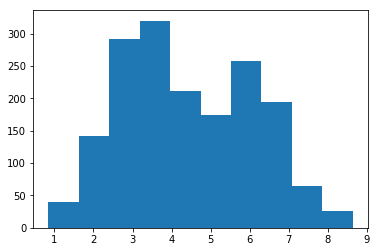

---
1270 languages processed. Avg cost: -279.8268981933594                
alpha = 0.005
17.025606155395508 1.0021930932998657


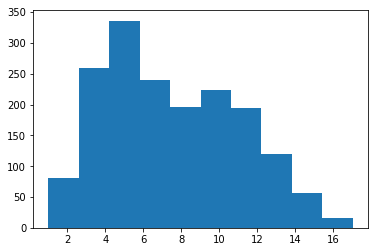

---
1270 languages processed. Avg cost: -1446.2766693115234               
alpha = 0.01
23.349727630615234 1.1824417114257812


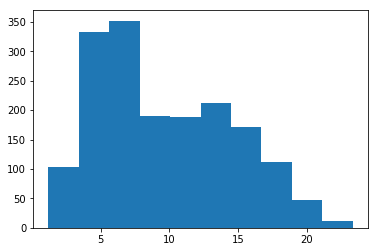

---
1270 languages processed. Avg cost: -6594.5244140625                  
alpha = 0.05
24.541080474853516 1.2900261878967285


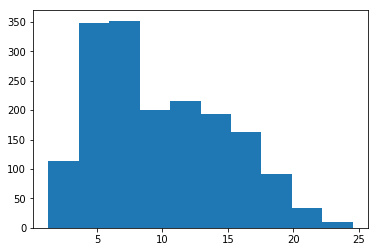

---
1270 languages processed. Avg cost: -15995.418798828125               
alpha = 0.1
24.875835418701172 1.2732070684432983


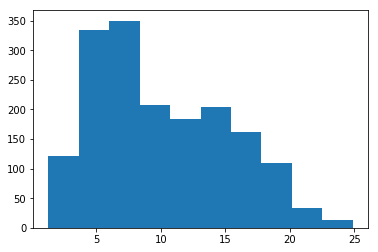

---
1270 languages processed. Avg cost: -78073.686328125                  
alpha = 0.5
25.04313850402832 1.2911219596862793


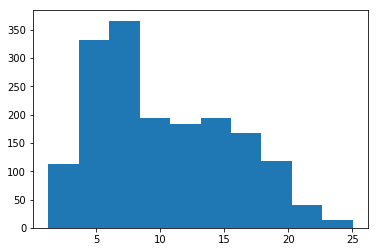

---
1270 languages processed. Avg cost: -208252.8828125                  
alpha = 1
25.915119171142578 1.3324223756790161


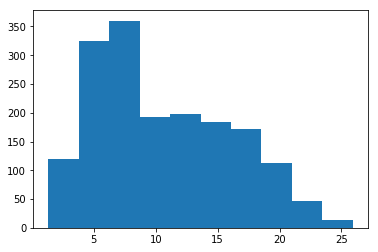

---


In [18]:
for alpha in [0.001,0.005,0.01,0.05,0.1,0.5,1]:
    
    emb = EmbedPhones(num_features)
    lr = 0.0002
    optimizer = optim.Adam(emb.parameters(),lr=lr,weight_decay=1.)
    
    epochs = 2
    costs = []
    for e in range(epochs):
        for step_num,allophone_data in enumerate(allophone_data_by_language_shuffled()):

            allophone_dists   = 0.
            nallophone_dists  = 0. 

            optimizer.zero_grad()

            for allophone_list in allophone_data:
                for i,j in distinct_pairs(len(allophone_list)):
                    allophone_dists += sqdist(emb(allophone_list[i]),emb(allophone_list[j]))
            for i,j in distinct_pairs(len(allophone_data)):
                for x in allophone_data[i]:
                    for y in allophone_data[j]:
                        nallophone_dists += sqdist(emb(x),emb(y))

            cost = allophone_dists - alpha * nallophone_dists
            cost.backward()
            costs.append(cost.item())
            if step_num%10==0:
                sys.stdout.write(str(step_num)+" languages processed. Avg cost: "+str(np.mean(costs))+"               \r")
                sys.stdout.flush()
                costs = []
            optimizer.step()


    ipa_chars = wg.load_ipa_chars('eng-Latn')

    dists = []
    for c1 in ipa_chars:
        for c2 in ipa_chars:
            s1,s2 = to_panphon_fts(c1),to_panphon_fts(c2)
            assert(len(s1)==1)
            assert(len(s2)==1)
            s1,s2 = s1[0],s2[0]
            if c1 != c2 : dists.append(dist(s1,s2))
    max_dist,min_dist = max(dists),min(dists)
    print("\nalpha =",alpha)
    print(max_dist,min_dist)
    plt.hist(dists)
    plt.show()
    print("---")

In [ ]:
emb = EmbedPhones(num_features)
lr = 0.0002
alpha = 0.05
lambda_ = 1.
optimizer = optim.Adam(emb.parameters(),lr=lr,weight_decay=lambda_)

epochs = 1
costs = []
costs_plot = []
for e in range(epochs):
    for step_num,allophone_data in enumerate(allophone_data_by_language_phoible_shuffled()):

        allophone_dists   = 0.
        nallophone_dists  = 0. 

        optimizer.zero_grad()

        for allophone_list in allophone_data:
            for i,j in distinct_pairs(len(allophone_list)):
                allophone_dists += sqdist(emb(allophone_list[i]),emb(allophone_list[j]))
        for i,j in distinct_pairs(len(allophone_data)):
            for x in allophone_data[i]:
                for y in allophone_data[j]:
                    nallophone_dists += sqdist(emb(x),emb(y))

        cost = allophone_dists - alpha * nallophone_dists
        cost.backward()
        costs.append(cost.item())
        if step_num%10==0:
            costs_plot.append(np.mean(costs))
            sys.stdout.write("Epoch "+str(e)+", "+str(step_num)+" languages processed. Avg cost: "+str(np.mean(costs))+"               \r")
            sys.stdout.flush()
            costs = []
        optimizer.step()


alpha = 0.05


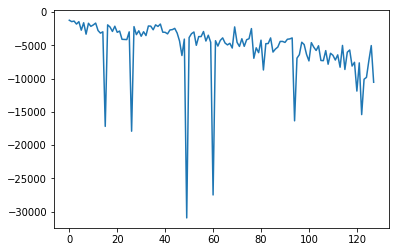

24.721477508544922 2.3966169357299805


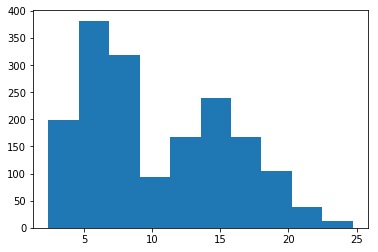

---


In [163]:
ipa_chars = wg.load_ipa_chars('eng-Latn')

dists = []
for c1 in ipa_chars:
    for c2 in ipa_chars:
        s1,s2 = to_phoible_fts(c1),to_phoible_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(dist(s1,s2))
max_dist,min_dist = max(dists),min(dists)
print("\nalpha =",alpha)
plt.plot(costs_plot)
plt.show()
print(max_dist,min_dist)
plt.hist(dists)
plt.show()
print("---")

In [178]:
ipa_charsets = ['eng-Latn','ind-Latn','ita-Latn','kaz-Cyrl','orm-Latn','pan-Guru']
ipa_chars = set()
for ipa_charset in ipa_charsets:
    ipa_chars = ipa_chars.union(wg.load_ipa_chars(ipa_charset))
ipa_chars.remove('ː')
ipa_chars.remove('̃')
ipa_chars = list(ipa_chars)
num_chars = len(ipa_chars)
print(num_chars,ipa_chars)

107 ['t͡ʃː', 'e', 'i̯', 'ɲ', 'kː', 'd', 'd͡ʒː', 'ɖ', 'b', 'hː', 'ɥ', 'ʒ', 'd̪', 'ɽ', 'ᶑ', 'kʼ', 'ɾ', 'ɕ', 'ʉ', 'ə', 'ɭ', 'ɕː', 'rː', 'ɔ', 't͡ʃʼ', 'ŋ', 'tʼː', 'ɲː', 'p', 'sː', 'zː', 'ʈʰ', 't͡ʃʼː', 't', 'l', 'ɡː', 'bː', 'ʌ', 'pʼː', 'q', 's', 'aː', 'h', 'tː', 'ɑ', 'ʈ', 'ʔ', 'j', 'a', 'ɪ', 'θ', 'u', 'i', 'm', 'd͡ʒ', 'o', 'kʼː', 'ʎ', 'iː', 'f', 'vː', 't͡ʃʰ', 'oː', 'jː', 'uː', 'ð', 'n̩', 'ʃ', 'x', 'ɳ', 'ʊ', 'pʼ', 'mː', 't͡ɕ', 'ʃː', 'k', 'v', 'nː', 't͡s', 'ɡ', 'pʰ', 'ɘ', 'tʼ', 'fː', 't̪', 'ʁ', 'pː', 'ɹ̩', 'r', 'w', 'æ', 't͡ʃ', 'ɹ', 'lː', 't̪ʰ', 'ɦ', 'z', 'm̩', 'n', 'dː', 'ʋ', 'ɣ', 'd͡ʑ', 'wː', 'kʰ', 'ɛ', 'eː']


In [181]:
projection = [n for n in range(num_chars)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = 40
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*500)
spread = step_size/2.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = np.random.normal(r0,spread)
    ipa_char_index = np.random.randint(num_chars)
    s0 = to_phoible_fts(ipa_chars[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_chars):
        s = to_phoible_fts(ipa_chars[n])
        assert(len(s)==1)
        s = s[0]
        if dist(s,s0)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break
        
for p in set(projection):
    print([ipa_chars[n] for n in range(num_chars) if projection[n]==p])

['t͡ʃʰ', 't͡ʃ']
['i̯']
['ɥ']
['ɽ', 'ɾ']
['kʼ', 'kʼː']
['ɕ', 'ɕː']
['rː', 'r']
['t͡ʃʼ', 't͡ʃʼː']
['ŋ']
['ɲ', 'ɲː']
['sː', 'zː', 's', 'z']
['ɭ', 'l', 'lː']
['b', 'p', 'bː', 'pʰ', 'pː']
['pʼː', 'pʼ']
['q']
['hː']
['d', 'ɖ', 'd̪', 'ᶑ', 'ʈʰ', 't', 'tː', 'ʈ', 't̪', 't̪ʰ', 'dː']
['ʔ']
['j', 'jː']
['θ', 'ð']
['t͡ʃː', 'd͡ʒː']
['ʎ']
['f', 'vː', 'v', 'fː']
['ʉ', 'ɔ', 'u', 'o', 'oː', 'uː', 'ʊ']
['n̩']
['ʒ', 'd͡ʒ', 'ʃ', 'ʃː']
['x', 'ɣ']
['m', 'mː']
['t͡ɕ', 'd͡ʑ']
['kː', 'ɡː', 'k', 'ɡ', 'kʰ']
['t͡s']
['tʼː', 'tʼ']
['ʁ']
['e', 'ə', 'ʌ', 'aː', 'ɑ', 'a', 'ɪ', 'i', 'iː', 'ɘ', 'æ', 'ɛ', 'eː']
['ɹ̩', 'ɹ']
['h', 'ɦ']
['m̩']
['ɳ', 'nː', 'n']
['ʋ']
['w', 'wː']
